    In dem vorliegenden Jupyter Notebook wird untersucht, welche Ursachen für Fehler in der Hochdruckkompressoreinheit (HPC) eines Flugzeugtriebwerks verantwortlich sind. Darüber hinaus sind unterschiedliche Sensoren in der Anwendung, um die verbleibende Nutzungsdauer (Remaining Useful life - kurz RUL) vorherzusagen.

**Definition - RUL Prognostik**

Die Prognostik ist eine technische Disziplin, die sich darauf konzentriert, den Zeitpunkt vorherzusagen, zu dem ein System oder eine Komponente ihre beabsichtigte Funktion nicht mehr erfüllen wird. Der zu erkennende Leistungsmangel führt häufig zu Fehlverhalten, ab dem das System nicht mehr zur Erfüllung der gewünschten Leistung verwendet werden kann. Die vorhergesagte Zeit bis zu dem Leistungsmangel wird dann Remaining Useful Life (RUL) genannt, die ein wichtiges Konzept für die Entscheidungsfindung zur Schadensminderung darstellt.


![Propulsion Engine](https://www.sdsc-bw.de/image/engine.png)

                                   Fig.1 Am Strahltriebwerk sind unterschiedliche Sensoren installiert.

## Das experimentelle Szenario
Die in diesem Beispiel verwendeten Datensätze nebst allen erforderlichen Informationen wie z.B. die Liste verwandter wissenschaftlicher Veröffentlichungen sind im NASA Ames Prognostics-Datenarchiv verfügbar: (https://data.nasa.gov/dataset/Turbofan-engine-degradation-simulation-data-set/vrks-gjie)

Informationen zum Problem finden Sie unter http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan und Originaldaten sind bei http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan verfügbar.

Die Daten wurden ursprünglich mit dem C-MAPPS-System (Commercial Modular Aero-Propulsion System Simulations) generiert. Wie in der folgenden Tabelle gezeigt wird, besteht der simulierte C-MAPSS-Datensatz aus 4 Unterdatensätzen mit unterschiedlichen Betriebs- und Fehlerbedingungen. Die Unterdatensätze (FD001, FD002 usw.) enthalten eine unterschiedliche Anzahl von Trainings- und Testtrajektorien:


| Data Set | Train trajectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |

Die Datensätze bestehen aus mehreren Zeitreihengruppen, wobei jede Zeitreihengruppe von einem Triebwerk stammt. Hierbei handelt es sich um Triebwerke desselben Typs. Alle Motoren laufen beim Start im normalen Zustand an und beginnen sich irgendwann während der Zeitreihe zu verschlechtern (Degradation). Die Degradation in den Trainingssätzen nimmt zu bis hin zu einem Ausfall. Die Degradation endet in den Testdatenätzen vor dem Ausfall, dass ist die RUL. Das Ziel besteht darin, mithilfe der verfügbaren Sensorinformationen die Anzahl der verbleibenden Betriebszyklen vor dem Ausfall vorherzusagen.

Jede Zeitreihengruppe enthält 26 Spalten: Motornummer, Zeitschritt, drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

| Column| Train trajectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |     
| ...  |        ...       |  
| 26   |        sensor measurement  3        |    

References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016


# Import aller benötigten Pakete

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
# Bibliothek speziell für die Visualisierung
import matplotlib.pyplot as plt
#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"

from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features, select_features

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\joezh\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Lesevorgang der Daten nebst Visualisierung

## Daten werden geladen

In [2]:
# Die Eingabedateien haben keine Spaltennamen, deshalb werden hier die Spaltennamen definiert.
# Enthalten sind 26 Spalten: Motornummer, Zeitschritt, drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [3]:
# Laden der Daten FD001 als Beispiel.
print("Laden der Daten beginnt!")
train_data = pd.read_csv('./data/train_FD001.txt', delim_whitespace=True, header=None)
train_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(train_data.shape[0], train_data.shape[1]))
train_data.head()

Laden der Daten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


    Die obige Tabelle zeigt nur die ersten fünf Zeilen des Trainingsdatensatzes. Die erste Spalte beinhaltet die Motornummer und die zweite Spalte die Anzahl der Zyklen. Aus der Abbildung ist ersichtlich, dass sich die Sensorinformation sowie die Arbeitsbedingungen sich in verschiedenen Zyklen geändert haben.

In [4]:
unit = train_data["UnitNumber"].unique()
print("In den Trainingsdaten sind {} Turbofan-Motoren enthalten.".format(len(unit)))

In den Trainingsdaten sind 100 Turbofan-Motoren enthalten.


**Unterschiedliche Motoren haben unterschiedliche Lebenszyklen**

In [5]:
motor_id = 1
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

Turbofan mit ID 1 lief insgesamt 192 Zyklen


In [6]:
motor_id = 2
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

Turbofan mit ID 2 lief insgesamt 287 Zyklen


**Die folgende Abbildung zeigt die Verteilung des Lebenszyklus von 100 Turbofan-Motoren in den Trainingsdaten.**

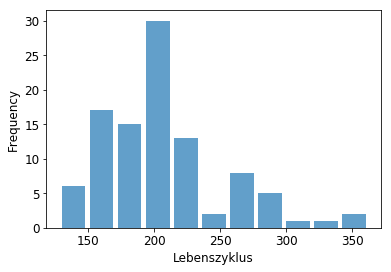

In [7]:
Zyklen_list = []
for ID in range(len(unit)):
    tmp = train_data[train_data["UnitNumber"]==ID+1]
    Zyklen_list.append(tmp.shape[0])
plt.hist(x=Zyklen_list, bins='auto',alpha=0.7, rwidth=0.85);
plt.xlabel('Lebenszyklus')
plt.ylabel('Frequency');

**Die folgende Abbildung zeigt den zeitlichen Verlauf von einem Turbofan-Motor. X Achse ist die Zyklusnummer, Y Achse entspricht den Sensorwerten**

       Zeitliche Verlauf von Turbofan mit id 2. X Axis is the Cycle Number, Y Axis is the Sensor Value 


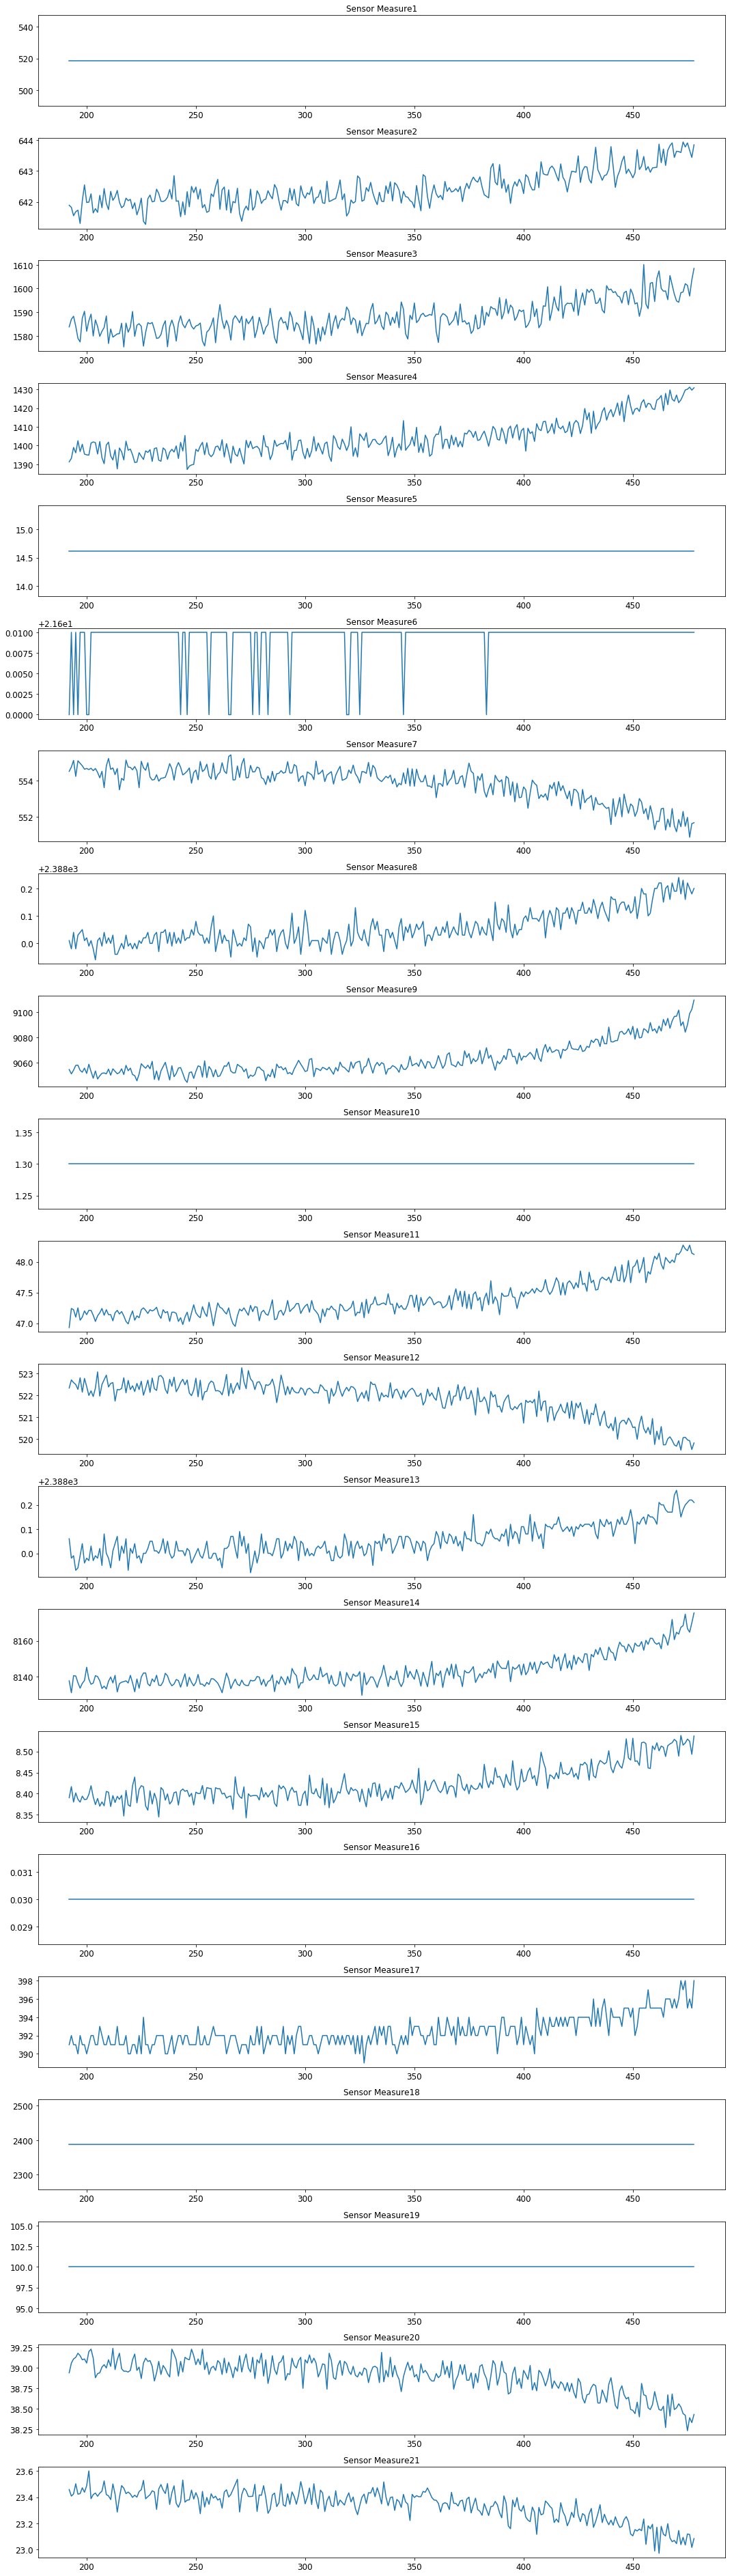

In [8]:
motor_id = 2
numberOfcolumns = len(sensor_measure_columns_names)
plt.figure(figsize=(15,2.5*len(sensor_measure_columns_names)))
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
for i,v in enumerate(range(numberOfcolumns)):
    a = plt.subplot(numberOfcolumns,1,v+1)
    a.plot(Dataframe_id.index.values,Dataframe_id.iloc[:,v+5].values)
    a.title.set_text(sensor_measure_columns_names[v])
    plt.tight_layout()
print("       Zeitliche Verlauf von Turbofan mit id {}. X Axis is the Cycle Number, Y Axis is the Sensor Value ".format(motor_id))
plt.show()

    Der Trend der Sensorwerte ist aus der obigen Abbildung deutlich ersichtlich. Die Werte der Sensoren beginnen sich ab einem bestimmten Moment zu ändern. Diese Änderungen hängen eng mit dem Zustand des Turbofan-Motors ab.

## RUL Berechnung
    Betreutes Lernen (Supervised-Learning) wird in der nächsten Analyse verwendet. Die Trainingsdaten enthalten jedoch keinen Y-Wert (RUL). Deshalb wird hier das lineare Degradationsmodell benutzt. Der Zeitschritt (Cycle / Zyklus) wird umgekehrt, und so die verbleibende Zeit einer Maschine beim Ausfall 1 beträgt.

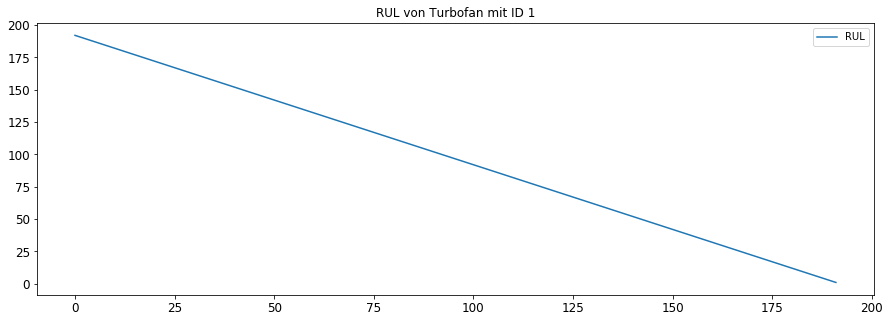

In [9]:

def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  
train_data['rul'] = train_data[['UnitNumber', 'Cycle']].groupby('UnitNumber').transform(f1)
plt.figure(figsize=(15,5))
motor_id = 1
df_of_id = train_data[train_data["UnitNumber"]==motor_id]
plt.plot(df_of_id.rul, label="RUL")
#plt.plot(df_of_id.Cycle, label="Cycle")
plt.legend()
plt.title("RUL von Turbofan mit ID {}".format(motor_id))
plt.show()

# Datenanalyse-Pipeline

## Merkmalsentwicklung (Feature-Development)
       Bei der Merkmalsentwicklung wird versucht, die Vorhersageleistung der Lernalgorithmen durch Erstellen von Merkmalen aus Rohdaten zu verbessern und mit diesen den Lernprozess zu vereinfachen. Die neuen Features sollen zusätzliche Informationen bereitstellen, die in den ursprünglichen oder vorhandenen Merkmalsgruppen nicht eindeutig erfasst werden können und oder nicht einfach ersichtlich sind. Der Prozess ist nicht trivial, fundierte und produktive Entscheidungen erfordern häufig ein gewisses Fachwissen.
       
      Wie in der folgenden Abbildung gezeigt wird, verwenden wir TSFRESH, um Zeitreihen-Features aus verschiedenen Domains automatisch zu extrahieren. (https://tsfresh.readthedocs.io/en/latest/index.html)

<img src=https://www.sdsc-bw.de/image/tsfresh.png  style="width: 600px;"/>

**Sliding Window Methode**

    Sliding Window Methode wird verwendet, um die Eingabe und Ausgabe zu Koppeln.
    
    Nehmen wir an, Sie haben eine Sensor-Zeitreihe. Nun möchten Sie ein Merkmal-basiertes Modell erstellen, um die RUL vorherzusagen. Sie müssen also in jedem Zeitschritt der ursprünglichen Zeitreihe Merkmale extrahieren, während Sie eine bestimmte Anzahl vergangener Werte betrachten. Ein Rollmechanismus (Sliding Window Methode) liefert Ihnen die Unterzeitserie der letzten k Zeitschritte zum Erstellen der Merkmale (Hier ist k die Window Size).

    Das folgende Bild zeigt den Vorgang. Das rote Kästchen ist die entsprechende RUL für jedes Fenster. Die Merkmalsentwicklung wird in jedem Fenster durchgeführt.

<img src=https://www.sdsc-bw.de/image/rolling.PNG  style="width: 600px;"/>



In [10]:
# Hier definieren wir die Fenstergröße mit 5
window_size = 5

engine_id = train_data["UnitNumber"].unique()
feature_x = pd.DataFrame()
RUL = pd.Series()


for index in tqdm(engine_id):
    
    data_frame = train_data[train_data["UnitNumber"]==index]
    add = pd.DataFrame(np.ones((1,data_frame.shape[1])), columns=data_frame.columns)
    data_frame = pd.concat([data_frame,add])
    data_frame.reset_index(inplace=True,drop=True)
    
    df_shift, _ = make_forecasting_frame(data_frame["Sensor Measure1"], kind="x", 
                                             max_timeshift = window_size, 
                                             rolling_direction=1)
    del df_shift["kind"]
    df_shift["Sensor Measure1"] = df_shift["value"]
    del df_shift["value"]
    for column in sensor_measure_columns_names[1:]:
        temp, _ = make_forecasting_frame(data_frame[column], kind="x", 
                                             max_timeshift = window_size, 
                                             rolling_direction=1)
        df_shift[column] = temp["value"]
    # Als Beispiel extrahieren wir nur einige grundlegende statistische Merkmale, wie z.B.: MEAN MAX MIN VARIANZ
    # Sie können die Einstellungen von default_fc_parameters ändern, um die zu extrahierenden Features auszuwählen.
    All_features = extract_features(df_shift, column_id="id", column_sort="time",
                                    default_fc_parameters=MinimalFCParameters(),
                                    impute_function=None, disable_progressbar=True,
                                    show_warnings=False, n_jobs=8)
    
    All_features=All_features.iloc[window_size-1:]
    y = data_frame["rul"].iloc[window_size-1:-1]
    
    feature_x = pd.concat([feature_x, All_features])
    RUL = pd.concat([RUL, y])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


In [11]:
RUL.reset_index(drop=True, inplace=True)

## Merkmalsverarbeitung

**Suche und Ööschung der Merkmale, die mit einem Bruchteil der fehlenden Werte über dem Schwellenwert liegen.**

In [12]:
def identify_and_remove_missing(Dataframe, Threshold=0.1):
    missing_series = pd.DataFrame( Dataframe.isnull().sum() / Dataframe.shape[0]).rename(columns = {'index': 'feature', 0: 'missing_fraction'})
    record_missing  = missing_series[missing_series["missing_fraction"]>Threshold]
    to_drop = list(record_missing.index)
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe
print("Größe vor der Verarbeitung ", feature_x.shape)
feature_x = identify_and_remove_missing(feature_x)
print("Größe nach der Verarbeitung ", feature_x.shape)

Größe vor der Verarbeitung  (20231, 168)
Größe nach der Verarbeitung  (20231, 168)


**Suche und Löschung der Merkmale, die mit nur einen einzigen eindeutigen Wert besitzen. NaNs zählen hierbei nicht als eindeutiger Wert.**

In [13]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'variable': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe
print("Größe vor der Verarbeitung ", feature_x.shape)
feature_x = identify_and_remove_unique_columns(feature_x)
print("Größe Nach der Verarbeitung", feature_x.shape)

Größe vor der Verarbeitung  (20231, 168)
Größe Nach der Verarbeitung (20231, 104)


**Merkmalsauswahl**

    Hier wird der Signifikanztest angewandt, um die Korrelation zwischen den extrahierten Merkmalen sowie der RUL (output) zu prüfen.

In [14]:
selected_features = select_features(feature_x, RUL.values.reshape(-1))
print("Größe vor der Auswahl ", feature_x.shape)
feature_x = identify_and_remove_missing(feature_x)
print("Größe nach der Auswahl ", feature_x.shape)

Größe vor der Auswahl  (20231, 104)
Größe nach der Auswahl  (20231, 104)


**Normalisierung**

In [15]:
def feature_sigmoid_transform(Featrues_DataFrame):
    """
    transform the operations into range(0,1)
    return transformed feature Frames , the median and IQR for each feature(columns) for new feature transformation
    this is excuted only when there are tsfresh fearues
    """

    # Interquartile range for each features
    Interquartile0_25 = np.array(Featrues_DataFrame.quantile(0.25))
    Interquartile0_75 = np.array(Featrues_DataFrame.quantile(0.75))
    IQR = Interquartile0_75 - Interquartile0_25

    # Median for each features
    median = np.array(Featrues_DataFrame.median())

    feature_columns = Featrues_DataFrame.columns
    # drop the features which has fast 0.0 Interquartile
    position = np.where( IQR == 0 )[0]

    Featrues_DataFrame.drop(Featrues_DataFrame.columns[position], axis=1, inplace = True)

    median = np.delete(median,position)
    IQR = np.delete(IQR,position)

    # sigmoid transformation
    transformed_features = (1+np.exp((-Featrues_DataFrame + median)/(IQR*1.2)))**(-1)

    return median, IQR, transformed_features

median, IQR, transformed_features = feature_sigmoid_transform(selected_features)

## Regressionsmodelle
    Das Jupyter-Notebook zeigt nur den grundlegenden Prozess der vorausschauenden Wartung - Predicitve Maintenance. Hier wurde nur ein einfaches Regressionsmodell gebaut. Ein automatisierter Analyseprozess (Modellauswahl und Hyperparameteroptimierung) wird im Jupyter-Notebook mit dem Namen AutoML_Turbofan_RUL.ipynb gezeigt.
    
    Neuronale Netze werden heute immer beliebter. Das neuronale Netzwerkmodell hat auch im Bereich der Predictive Maintenance gute Ergebnisse erzielt. Tiefergehende Details finden Sie in Jyputer Notebook namens DeepConvLSTM_Turbofan_RUL.ipynb.

In [16]:
# Modellinitialisierung
model = lgb.LGBMRegressor(random_state=12)
# Modelltraining
model.fit(transformed_features, RUL)

LGBMRegressor(random_state=12)

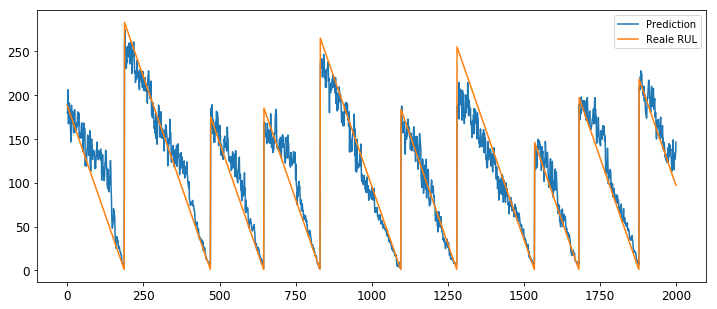

In [17]:
prediction = model.predict(transformed_features)
plt.figure(figsize=(12,5))
plt.plot((prediction[:2000]), label="Prediction")
plt.plot((RUL[:2000]), label="Reale RUL")
plt.legend()
plt.show()

    Wie aus der obigen Abbildung ersichtlich ist, ist der Trend der Turbofan-Motoren Degradation (Leistungsminderung) lernbar, obwohl es einen Unterschied zwischen dem vorhergesagten Wert und dem wahren Wert gibt.

**Evaluationsmetrik Root-Mean-Square-Error**

In [18]:
rms = sqrt(mean_squared_error(RUL.values.reshape(-1), prediction))
print("Der RMSE auf die Trainingsdaten lautet :", rms)

Der RMSE auf die Trainingsdaten lautet : 25.60541415619369


# Evaluation
    Performance der Testdaten

## Laden der Testdaten

In [19]:
print("Laden der Testdaten beginnt!")
test_data = pd.read_csv('./data/test_FD001.txt', delim_whitespace=True, header=None)
test_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(test_data.shape[0], test_data.shape[1]))
test_data.head()

Laden der Testdaten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 13096, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [20]:
# Reale RUL
RUL_FD001 = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True)

## Merkmalsberechnung

In [21]:
engine_id = test_data["UnitNumber"].unique()
window_size = 5
feature_x = pd.DataFrame()
feature_columns = transformed_features.columns

for index in tqdm(engine_id):
    data_frame = test_data[test_data["UnitNumber"]==index]
    # Hier werden nur die Informationen zur letzten Fenstergröße verwendet. 
    data_frame = data_frame.iloc[-window_size:]
    data_frame = data_frame[sensor_measure_columns_names]
    data_frame["id"] = 1
    data_frame["time"] = range(data_frame.shape[0])
    data_frame.reset_index(inplace=True,drop=True)



    All_features = extract_features(data_frame, column_id="id", column_sort="time", #column_value="value", 
                                    default_fc_parameters=MinimalFCParameters(),
                                    impute_function=None, disable_progressbar=True,
                                    show_warnings=False, n_jobs=8)

    All_features = All_features[feature_columns]
    

    feature_x = pd.concat([feature_x, All_features])
    


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


## Evaluation

In [22]:
# Merkmalstransformation
transformed_features = (1+np.exp((-feature_x + median)/(IQR*1.2)))**(-1)


prediction = model.predict(transformed_features)
prediction = np.round(prediction)

rms = sqrt(mean_squared_error(RUL_FD001.values.reshape(-1), prediction))
print("Der RMSE auf die Testdaten lautet :", rms)

Der RMSE auf die Testdaten lautet : 33.59970237963426


<span class="girk">**Das beste aktuelle Ergebnis lautet 29 mittels RMSE.**</span>

## Wichtige Merkmale

In [23]:
feature_names = list(transformed_features.columns)
feature_importance_values = model.feature_importances_
# Notierung der Wichtigkeitkeint der Merkmale
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

# Sortierung der Merkmale nach ihrer Wichtigkeit
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

# Normalisierung die Merkmals-Wichtigkeiten, um bis zum Wert Eins zu addieren
feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

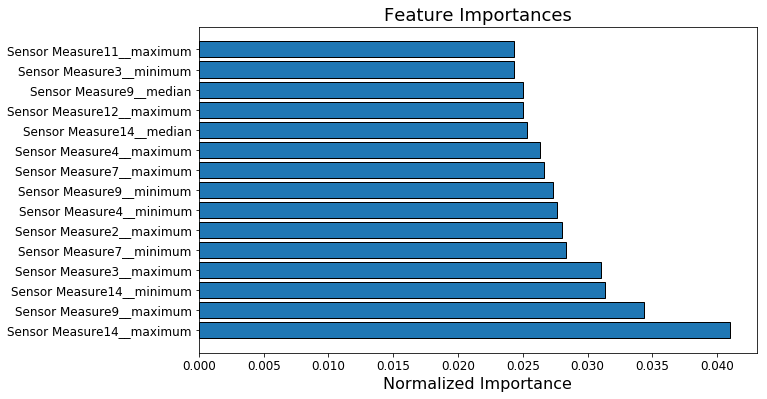

In [24]:
plot_n = 15
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(reversed(list(feature_importances["feature"][:plot_n]))), 
        feature_importances['normalized_importance'][:plot_n], 
        align = 'center', edgecolor = 'k')
ax.set_yticks(list(reversed(list(feature_importances["feature"][:plot_n]))))
ax.set_yticklabels(feature_importances['feature'][:plot_n], size = 12)

# Plot Labeling
plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
plt.show()